In [134]:
import csv
import numpy as np
import pandas as pd
import pylab as p
%matplotlib inline  
train = pd.read_csv('train.csv', header = 0)
test = pd.read_csv('test.csv', header = 0)

In [135]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [136]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


With the exploratory visualization from the last point, we have some idea what out data looks like. We know that the survival rate is in some way related to Pclass, Sex, Age, Fare and Embarked, but we haven't got any chance to explore the rest of the predicators. So, let's start building models and making predictions. 

### Gender-based Model

From last post, we know that the most influential predicator in the data set is Sex, as survival rate differs dramatically between male and female passengers. Given the low survival rate of male and high survival rate of female, the easiest possible model is to simply predict 0 for male and 1 for female.

In [137]:
#simply creating a Survival variable, mappped from the Sex variable
test['Survived'] = test['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

The output of the head() function tells us our change to the data frame is effective and we have already made our first prediction! Next, we just need to export the data to a csv file and submit to Kaggle.

In [138]:
prediction_file = open("Gender-BasedModel.csv", "wb")
out = csv.writer(prediction_file)
out.writerow(["PassengerId", "Survived"])
for i in range(0, len(test.PassengerId)):
    out.writerow([test.PassengerId[i], test.Survived[i]])
prediction_file.close()

The results of the gender-based prediction was **0.76555**, which is surprisingly good for a single line of prediction code! Of course we are not going to call it a day. Let's see if we could incorporate Pclass or Age in the model. Now we are including more predicators, so predicting based on a few logical conditions will be hard to accomplished. It is time to bring in some models. But before that, we need to clean our data.  
### Data Cleaning
However, before we can do that, we need to clean our data. We see that there are NAs in the Age, Fare, Cabin, and Embarked variables, so we will have to impute these values. For the Cabin variable, there are way too many NAs so imputing all those values would bring it an significant amount of noise. And the Cabin variable itself is hard to interpret anyways. So we will just impute the Age, Fare and Embarked variables.

In [139]:
def clean_data(df):
    # simply fill the missing Embarked value with "S" since there are only 2 NAs
    df.Embarked = train.Embarked.fillna('S')
    
    # there is a 0 value in Fare column, which is unreasonable. Will have to replace it with NA first.
    df.Fare = df.Fare.map(lambda x: np.nan if x==0 else x)
    #build a pivot table to impute NAs with averaged Fare for all Pclass
    fare_pivot_table = df.pivot_table("Fare", index='Pclass', aggfunc='mean', dropna=True)
    #use pivot table to impute missing fare values
    df.Fare = df[['Fare', 'Pclass']].apply(lambda x: fare_pivot_table[x['Pclass']] if pd.isnull(x['Fare']) else x['Fare'], axis = 1)
    
    #build a pivot table to impute NAs with median Age according to Pclass and Sex
    age_pivot_table = df.pivot_table('Age', index=['Pclass','Sex'], aggfunc='median',dropna=True)
    df.Age = df[['Sex', 'Pclass', 'Age']].apply(lambda x: age_pivot_table[x.Pclass, x.Sex] if pd.isnull(x.Age) else x.Age, axis = 1)
    
    # Here we are adding interaction terms between predicators. I have included a few reasonable interaction terms in my mind 
    df['Family_Size']=train['SibSp']+train['Parch']
    df['FarePerFamilyMember']=train['Fare']/(train['Family_Size']+1)

    return df

In [140]:
train = clean_data(train)
test = clean_data(test)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point




### Logistic Regression
Now it is time to bring in some model and add in predicators. Let's try our hands at [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) first, since it is one of the most interpretable classification model in my opinion. We'll start with an extremely simple case of just 2 predicators: Pclass and Sex  

In [154]:
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
#setting formula to predict Survived with Pclass and Sex
formula1 = 'Survived ~ C(Pclass) + C(Sex)'
train_response,train_data = dmatrices(formula1, data=train, return_type="dataframe")
test_response,test_data = dmatrices(formula1, data=test, return_type="dataframe")
LRmodel = LogisticRegression()
LRmodel.fit(train_data.values, train_response.values.ravel())
LRoutput1 = LRmodel.predict(test_data).astype(int)
prediction_file = open("Gender-PclassBasedModel.csv", "wb")
out = csv.writer(prediction_file)
out.writerow(["PassengerId", "Survived"])
for i in range(0, len(test.PassengerId)):
    out.writerow([test.PassengerId[i], LRoutput1[i]])
prediction_file.close()

Seems like we got the exact same result 0.76555 again. Why is that? Shouldn't an adding an predicator change some of our predictions? Here is why. 

In [155]:
for i in range(0,2):
    for j in range(0,2):
        for k in range(0,2):
            if i == 1:
                Pclass = 2
            elif j == 1:
                Pclass = 3
            else: 
                Pclass = 1
            if i == j ==1:
                break    
            if k ==1:
                sex = "male"
            else:
                sex = "female"
            print "Given Pclass = %d and Sex = %s, predict %d for survival. " % (Pclass,sex, LRmodel.predict([[1,i,j,k]])) 

Given Pclass = 1 and Sex = female, predict 1 for survival. 
Given Pclass = 1 and Sex = male, predict 0 for survival. 
Given Pclass = 3 and Sex = female, predict 1 for survival. 
Given Pclass = 3 and Sex = male, predict 0 for survival. 
Given Pclass = 2 and Sex = female, predict 1 for survival. 
Given Pclass = 2 and Sex = male, predict 0 for survival. 


In [156]:
print train.pivot_table('Survived', index=['Pclass','Sex'], aggfunc='mean')

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64


Turns out that the predications stays the same, with or without the Pclass prediactor. Logistic Regression computes the probabilities for each response and predicts the response with largest likelihood. In this case, as we can see from the above pivot table, the most probable survival response for female is 1 and 0 for male, despite the change in survival rate due to Pclass, which is why the predictions stay the same.  

Even though we didn't improve the model with the addition of the Pclass predicators, our effort was not totally worthless. Now we can add more variables to the Logistic Regression, hoping it would produce a more accurate prediction with the extra data. But how do we know that a full model is better than a 5-predicator model or a 7-prediactor model? Time for feature selection. Here we use a recursion feature elimination technique and use cross validation to evaluate the test accuracy of models. A good reference example for RFECV is [here](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html)



Optimal number of features : 10


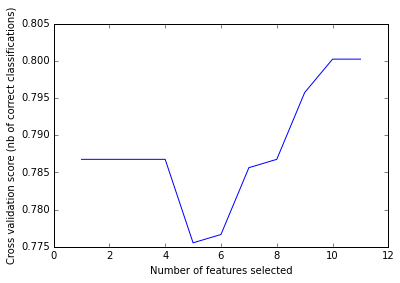

In [159]:
formula2 = 'Survived ~ C(Pclass) + C(Sex)  + Age + SibSp + Parch + Family_Size + FarePerFamilyMember + C(Embarked)'
train_response,train_data = dmatrices(formula2, data=train, return_type="dataframe")
test_response,test_data = dmatrices(formula2, data=test, return_type="dataframe")

from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=LogisticRegression(), scoring='accuracy')
rfecv.fit(train_data.values, train_response.values.ravel())
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
p.figure()
p.xlabel("Number of features selected")
p.ylabel("Cross validation score (nb of correct classifications)")
p.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
p.show()

The RFECV confirmes that our full model of 10 prediactors has the best CV error

In [160]:
LRmodel2 = LogisticRegression()
LRmodel2.fit(train_data.values, train_response.values.ravel())
LRoutput2 = LRmodel2.predict(test_data).astype(int)
prediction_file = open("LRModel.csv", "wb")
out = csv.writer(prediction_file)
out.writerow(["PassengerId", "Survived"])
for i in range(0, len(test.PassengerId)):
    out.writerow([test.PassengerId[i], LRoutput2[i]])
prediction_file.close()

We got **0.77033** this times, which is an improvement over the 2-predicator Logistic Regression. Hooray! But do we still have space for improvement? Of course we do. We can either try another model, or dig more out of the data. There is a Name Column, which could be helpful in some ways. Maybe a more noble title indicates a higher social status and a higher survival rate. Maybe a family that shares the same lastname all perished or survived. Who knows? 